## 1.数据预处理阶段

In [20]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
fi_id_nfi_dict_path = "./data/fi_nfi_id.pkl"
feature_id_time_spatial_path = "./data/feature_id_time_spatial.pkl"
Best_label_cluster_path = "./processing/Best_label_cluster.pkl"


fi_id_nfi_dict = np.load(fi_id_nfi_dict_path, allow_pickle=True)
Best_label_cluster  = np.load(Best_label_cluster_path, allow_pickle=True)
feature_id_time_spatial = np.load(feature_id_time_spatial_path, allow_pickle=True)
# print(Best_label_cluster)
# print(feature_id_time_spatial)
# print(fi_id_nfi_dict)

## 2.频谱图的构建

In [21]:

def spectrogram_draw(data):
    duration_time = 2
    x = np.arange(0, duration_time, 0.01)
    plt.plot(x, data)
    NFFT = 200
    Fs = 100
    plt.show()
    Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=0)
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()

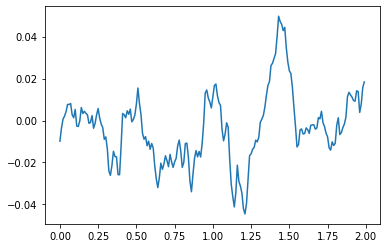

/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  if __name__ == '__main__':


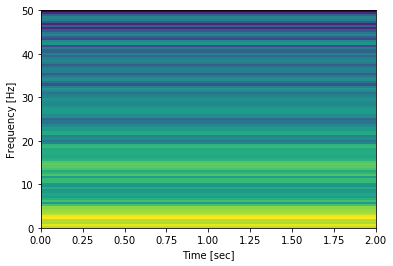

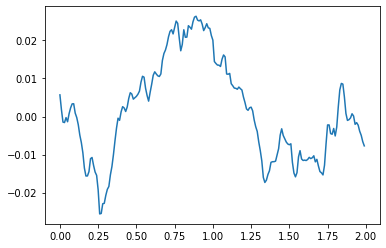

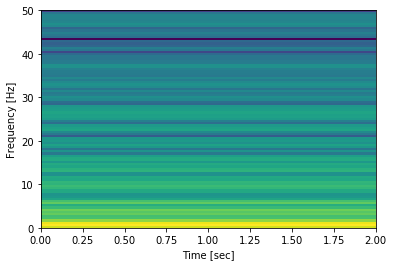

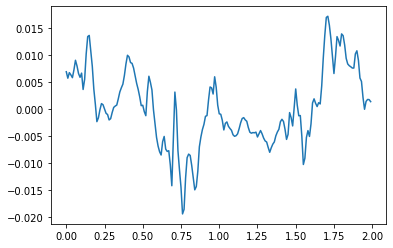

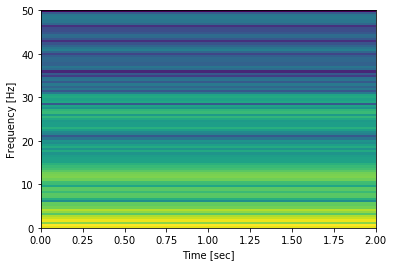

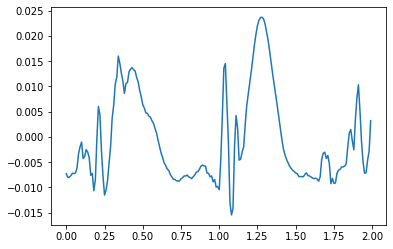

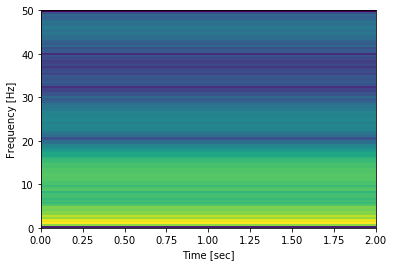

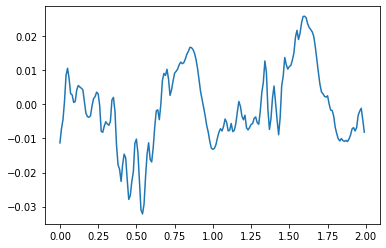

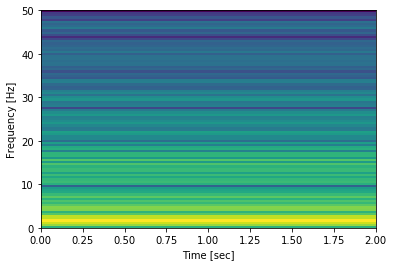

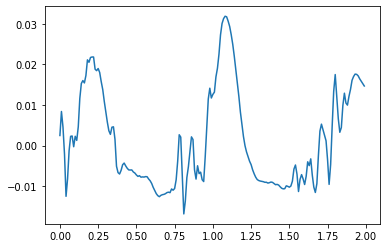

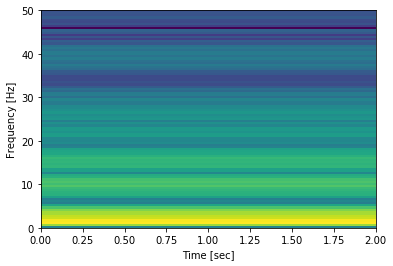

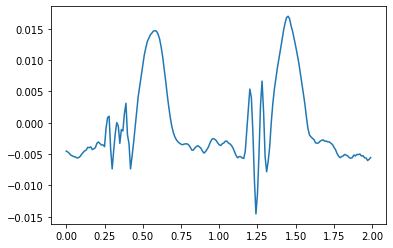

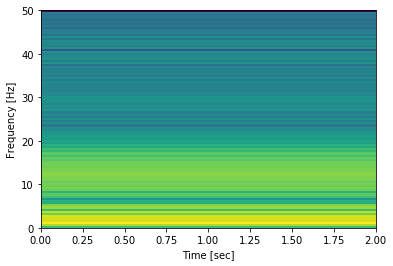

In [48]:
for cluster_id, fi_ids in Best_label_cluster.items():
    data_y = np.zeros(200)
    for fi_id in fi_ids:
        # print(fi_id)
        # raw_data_path = fi_id_nfi_dict
        raw_data_nfi = np.load(fi_id_nfi_dict[fi_id]['nfi_path'], allow_pickle=True)
        channel_spot = feature_id_time_spatial[fi_id]["spatial"]
        channel_data = raw_data_nfi[channel_spot]
        data_y += channel_data
    # print(data_y)
    spectrogram_draw(data_y)
    
    
    
    

### 2.1 频谱图功能测试

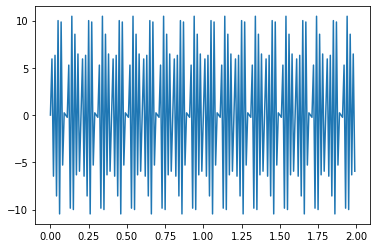

/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  if __name__ == '__main__':


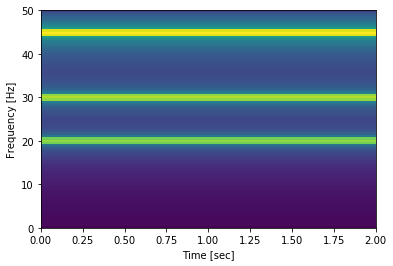

200


In [59]:
def specgram_draw(data):
    duration_time = 2
    dt = 0.01
    x = np.arange(0.0, duration_time, dt)
    plt.plot(x, data)
    NFFT = 200
    Fs = 100
    plt.show()
    Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=0)
    # The `specgram` method returns 4 objects. They are:
    # - Pxx: the periodogram
    # - freqs: the frequency vector
    # - bins: the centers of the time bins
    # - im: the matplotlib.image.AxesImage instance representing the data in the plot
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()
t = np.arange(0, 2, 0.01)
s1 = np.sin(2 * np.pi * 20 * t)
s2 = 2 * np.sin(2 * np.pi * 30 * t)
y  = s1+s2+10 * np.sin(2 * np.pi * 45 * t)
specgram_draw(y)
print(len(y))

## 3.相似度较高的数据展示

In [22]:
from dtw import dtw
from tqdm.notebook import tqdm as tqdm

def similarity_DTW(s1, s2):
    ratio = 50 # 设定的放缩系数，避免数据的相似度过于集中
    euclidean_norm = lambda x, y: np.abs(ratio * (x - y))
    d, cost_matrix, acc_cost_matrix, path = dtw(s1, s2, dist=euclidean_norm)
    score = 1 - np.tanh(d)  # 相似度的评分【0,1】 0： 完全不同， 1： 完全相同
    return score

def get_top_score_series(series_dict, dba_wave, top_n = 5):
    top_wave_cluster = {}
    for cluster_id, feature_data in tqdm(series_dict.items()):
        dba_w = dba_wave[cluster_id]
        cluster_score ={}
        for _d, _id in tqdm(feature_data):
            score = similarity_DTW(_d, dba_w)
            cluster_score[_id] = score
        cluster_result = sorted(cluster_score.items(), key=lambda x:-x[1])
        top_wave_cluster[cluster_id] = cluster_result[:top_n]
    return top_wave_cluster
wave_clusters_id_feature_data_path = "./processing/wave_clusters_id_feature_data.pkl"
DBA_wave_path = "./processing/DBA_wave.pkl"
wave_clusters_id_feature_data = np.load(wave_clusters_id_feature_data_path, allow_pickle=True)
DBA_wave = np.load(DBA_wave_path, allow_pickle=True)
top_wave_cluster = get_top_score_series(wave_clusters_id_feature_data, DBA_wave)

{0: [('b12e6627-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9035777763575508), ('b12e68b6-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9030095342234458), ('a5531f79-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.9024187817460604), ('a5c1d723-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.9021862941770313), ('a5c1d7f5-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.9014846099252783)], 1: [('a4e5e54c-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8593668085026583), ('a59dceb7-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8248858142215387), ('a5c1d938-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8155514489689899), ('a5c1d8ae-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8120264601765239), ('a4e5e306-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8091311453418155)], 3: [('a52f3903-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8169334099205154), ('a5531f9e-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.7813889108998164), ('a5531fd5-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.7237061409591286), ('a5532083-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.7210837622207724), ('a52f3adb-fa3a-11e9-a8f2-e0d55e6

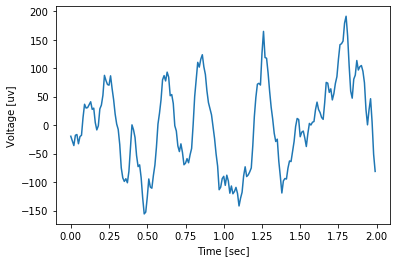

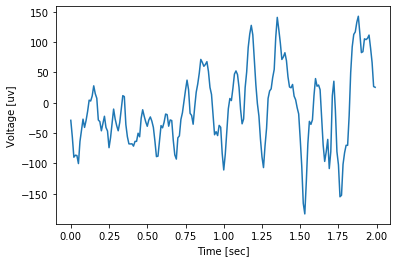

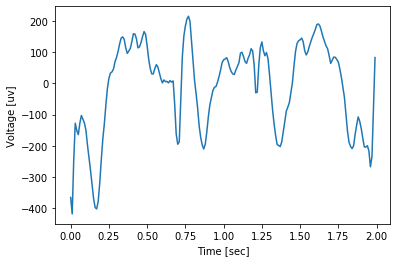

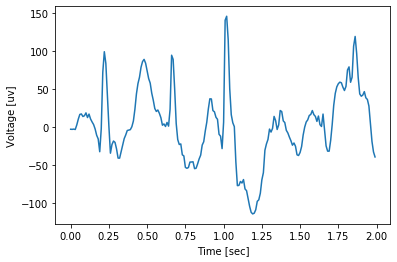

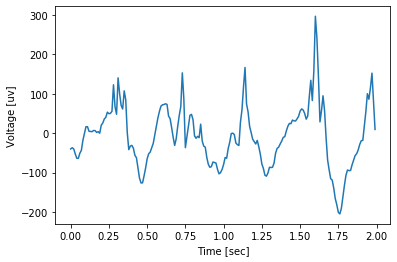

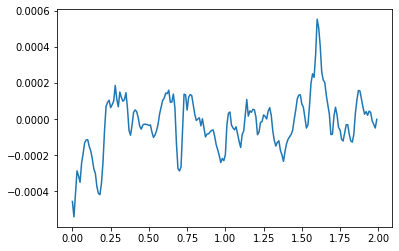

/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  


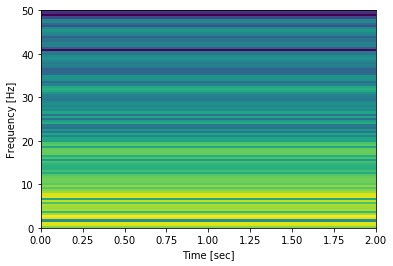

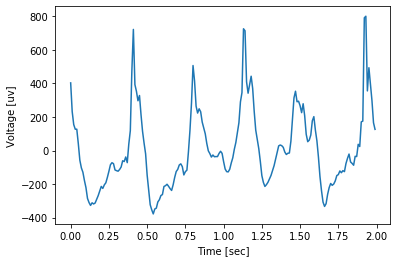

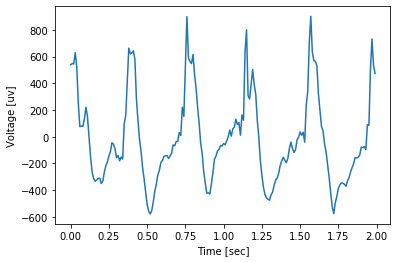

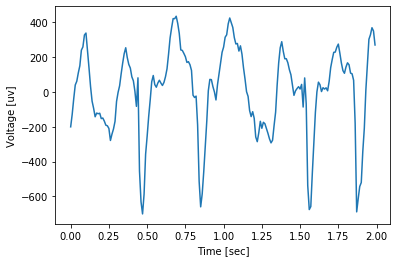

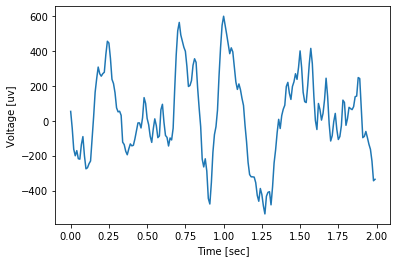

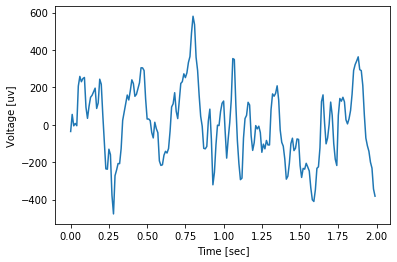

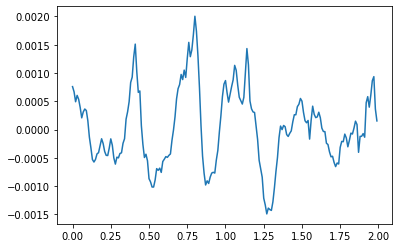

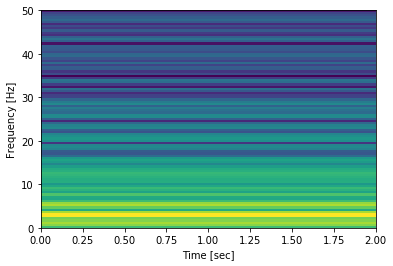

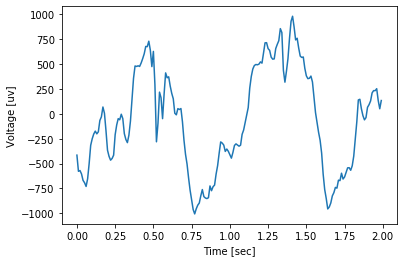

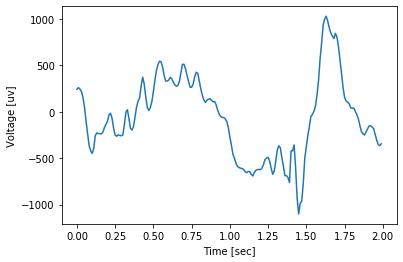

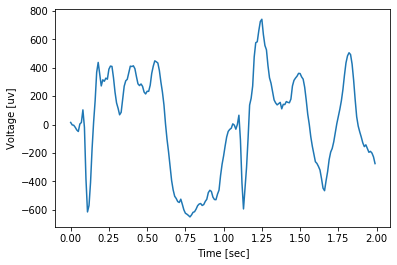

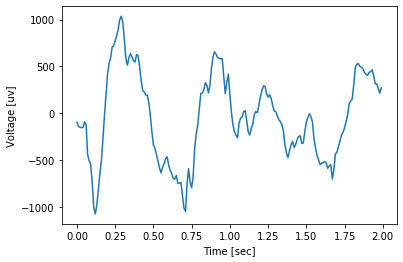

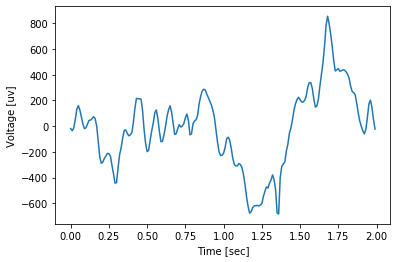

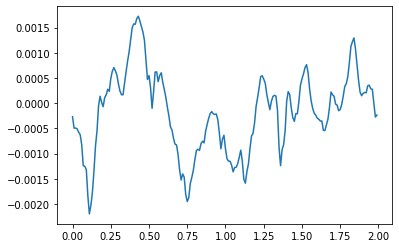

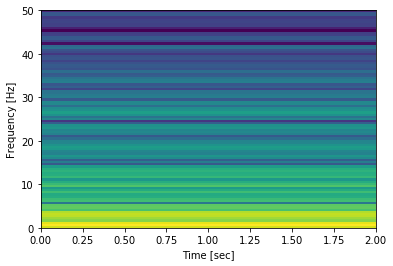

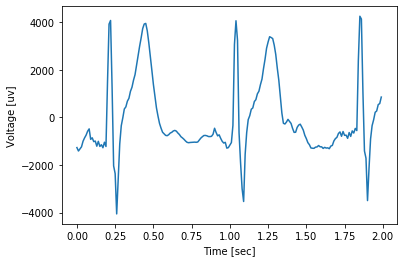

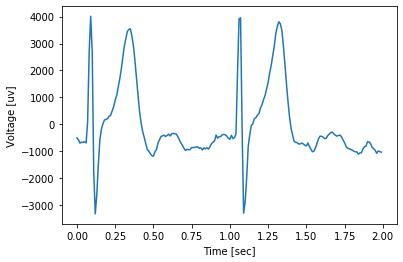

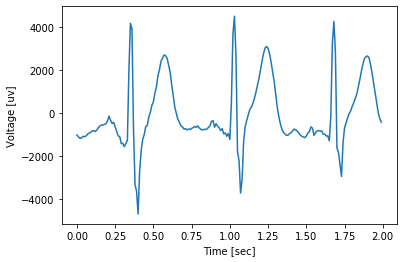

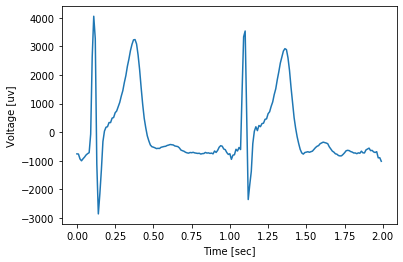

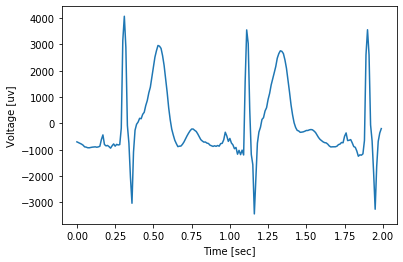

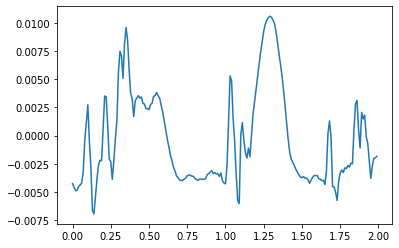

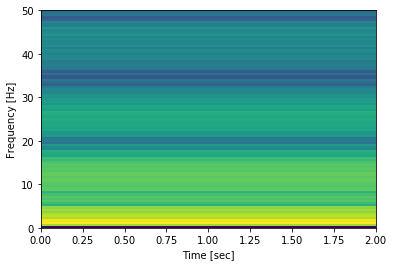

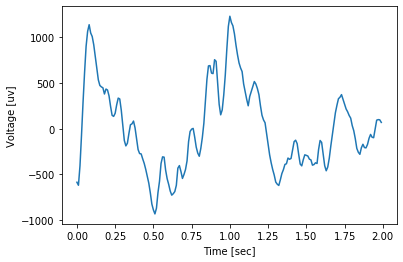

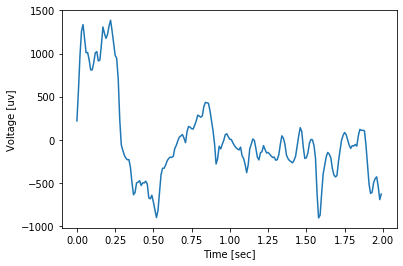

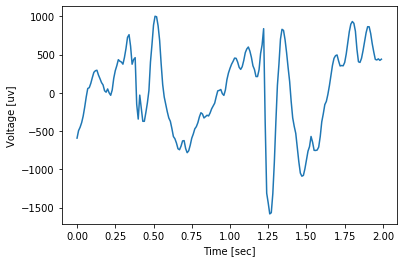

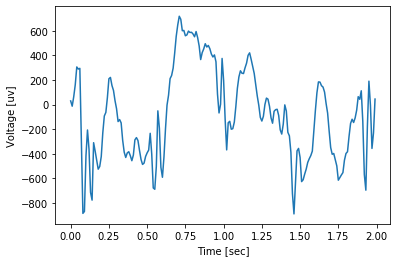

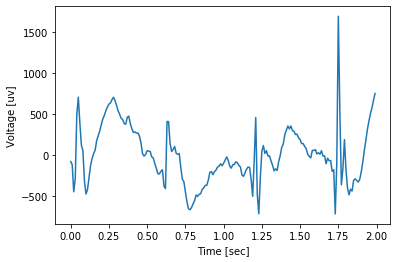

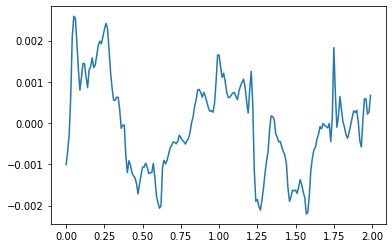

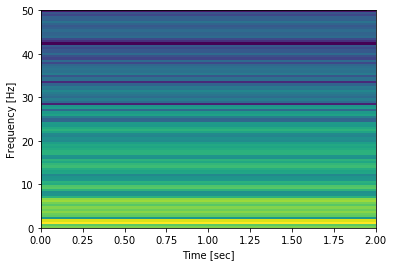

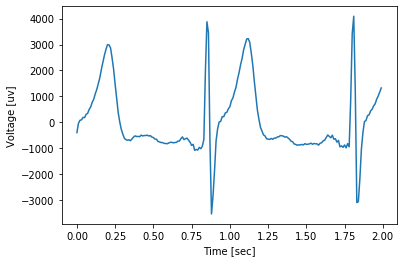

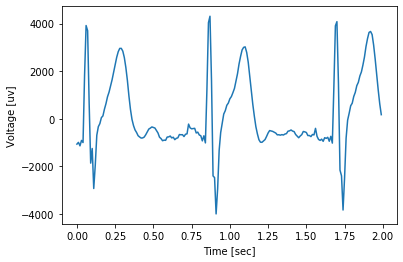

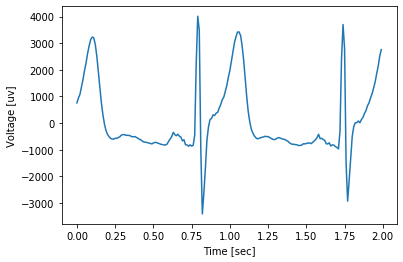

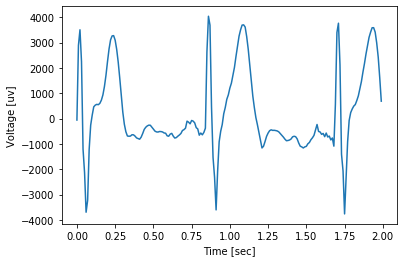

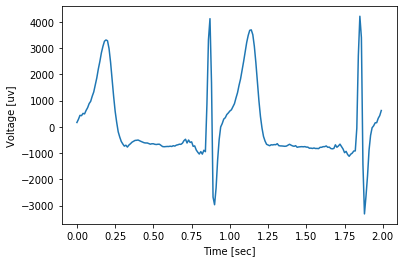

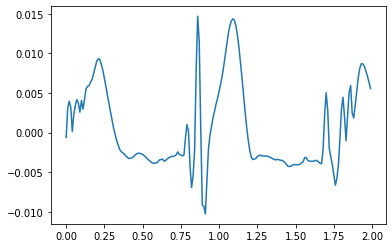

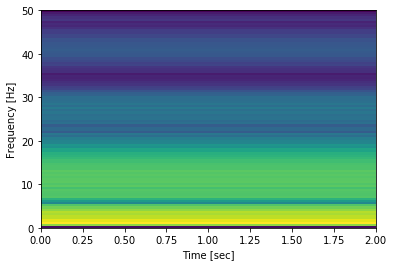

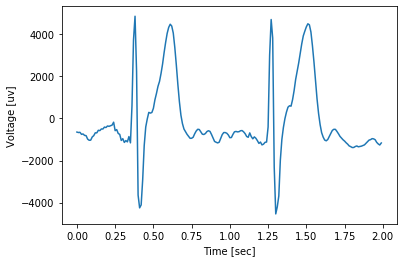

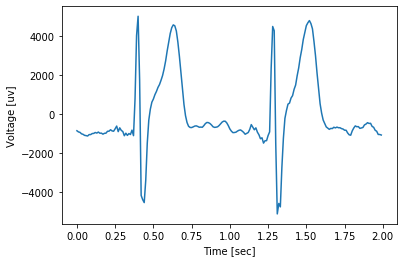

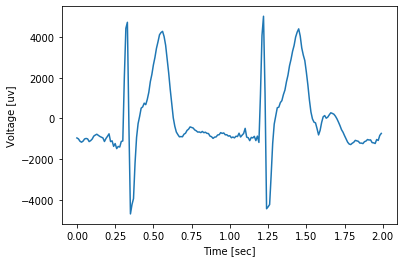

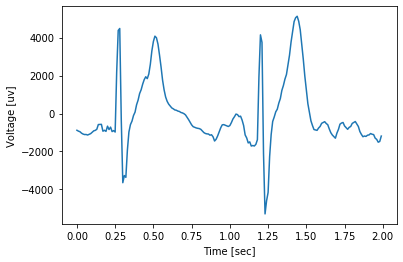

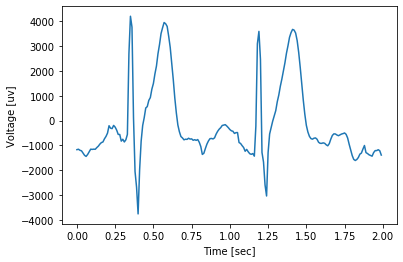

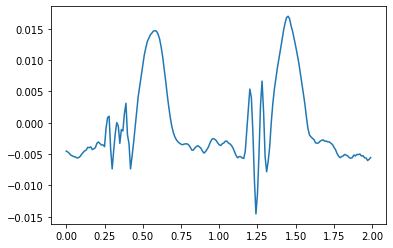

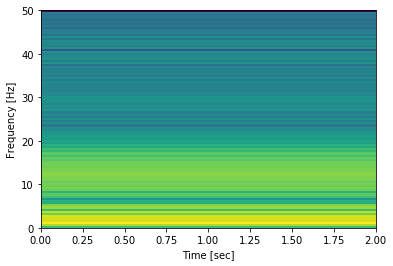

In [24]:
print(top_wave_cluster)
for cluster_id, feature_ids in top_wave_cluster.items():
    print("Cluster ID{}".format(cluster_id))
    y_spectrogram = np.zeros(200)
    for f_id, _ in feature_ids:
        raw_path = fi_id_nfi_dict[f_id]["nfi_path"]
        channel_no = feature_id_time_spatial[f_id]["spatial"]
        raw_data_channel = np.load(raw_path)[channel_no]
        x = np.arange(0, 2, 0.01)
        y_spectrogram += raw_data_channel
        plt.plot(x, raw_data_channel*1e6)
        plt.xlabel("Time [sec]")
        plt.ylabel("Voltage [uv]")
        plt.show()
    spectrogram_draw(y_spectrogram)
        